In [2]:

! pip install python-Levenshtein
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import lru_cache
from Levenshtein import distance as levenshtein_distance
from collections import defaultdict
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Прочтение таблиц

In [4]:
df = pd.read_excel("/content/drive/MyDrive/BioCode/Boss.xlsx")
df.head()

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
0,0,31126,0.020801,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3
1,1,22574,0.015086,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1
2,2,21496,0.014366,TGTGCCAGCAGTCTCCGGACAGATCCTTGGGATGAGCAGTTCTTC,CASSLRTDPWDEQFF,TRBV12-4,TRBJ2-1
3,3,21336,0.014259,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6
4,4,20032,0.013387,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7


In [5]:
database = pd.read_excel("/content/drive/MyDrive/BioCode/vdjdb.slim.xlsx")

In [6]:
database_exp = database.rename(columns={'cdr3': 'CDR3.amino.acid.sequence'})

In [7]:
df = df.sort_values(by='Read.count', ascending=False)
df

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
0,0,31126,2.080130e-02,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3
1,1,22574,1.508605e-02,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1
2,2,21496,1.436563e-02,TGTGCCAGCAGTCTCCGGACAGATCCTTGGGATGAGCAGTTCTTC,CASSLRTDPWDEQFF,TRBV12-4,TRBJ2-1
3,3,21336,1.425871e-02,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6
4,4,20032,1.338725e-02,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7
...,...,...,...,...,...,...,...
356719,449315,1,6.682933e-07,TGTGCCAGCACCCCTTCTGAGACAGACTATGGCTACACCTTC,CASTPSETDYGYTF,TRBV7-8,TRBJ1-2
356718,344535,1,6.682933e-07,TGTGCCAGCACCCCTTCGGGGAGCTCCTACAATGAGCAGTTCTTC,CASTPSGSSYNEQFF,TRBV3-1,TRBJ2-1
356717,545084,1,6.682933e-07,TGTGCCAGCACCCCTTCGGGGAACACTGAAGCTTTCTTT,CASTPSGNTEAFF,TRBV6-1,TRBJ1-1
356716,545085,1,6.682933e-07,TGTGCCAGCACCCCTTCGGGAGGGGCAAAACTGTTTTTT,CASTPSGGAKLFF,TRBV12-3,TRBJ1-4


In [8]:
data_claster = df[:3000]
data_claster

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
0,0,31126,0.020801,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3
1,1,22574,0.015086,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1
2,2,21496,0.014366,TGTGCCAGCAGTCTCCGGACAGATCCTTGGGATGAGCAGTTCTTC,CASSLRTDPWDEQFF,TRBV12-4,TRBJ2-1
3,3,21336,0.014259,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6
4,4,20032,0.013387,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7
...,...,...,...,...,...,...,...
3103,3114,23,0.000015,TGTGCCAGCAGCTTAGGGCAGGTCAATGAGCAGTTCTTC,CASSLGQVNEQFF,TRBV13,TRBJ2-1
3116,3081,23,0.000015,TGTGCCAGCAGTCCAGGGGAAATCGCCTACGAGCAGTACTTC,CASSPGEIAYEQYF,TRBV6-2,TRBJ2-7
3101,3022,23,0.000015,TGTGCCAGCAGCTTAGCAGGGTCCCAGTATAATTCACCCCTCCACTTT,CASSLAGSQYNSPLHF,TRBV7-9,TRBJ1-6
3100,3021,23,0.000015,TGTGCCAGCAGCTTAGCAGCCCAGCGGGAGAGAAATGAGCAGTTCTTC,CASSLAAQRERNEQFF,TRBV7-2,TRBJ2-1


# Функция кластеризации

In [9]:
# Кэшированная функция для вычисления расстояния Левенштейна
@lru_cache(maxsize=None)
def cached_levenshtein_distance(seq1, seq2):
    return levenshtein_distance(seq1, seq2)

# Функция для кластеризации последовательностей
def cluster_sequences(sequences, max_distance=1):
    clusters = []
    for seq in sequences:
        added_to_cluster = False
        for cluster in clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for existing_seq in cluster):
                cluster.append(seq)
                added_to_cluster = True
                break
        if not added_to_cluster:
            clusters.append([seq])
    return clusters

# Функция для объединения кластеров
def merge_clusters(clusters, max_distance=1):
    merged_clusters = []
    for cluster in clusters:
        added_to_cluster = False
        for merged_cluster in merged_clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for seq in cluster for existing_seq in merged_cluster):
                merged_cluster.extend(cluster)
                added_to_cluster = True
                break
        if not added_to_cluster:
            merged_clusters.append(cluster)
    return merged_clusters

# Пример последовательностей аминокислот
sequences = data_claster['CDR3.amino.acid.sequence']

# Разделение данных на части
chunk_size = len(sequences) // 100
chunks = [sequences[i:i + chunk_size] for i in range(0, len(sequences), chunk_size)]

# Кластеризация каждой части
all_clusters = []
for chunk in chunks:
    all_clusters.extend(cluster_sequences(chunk, max_distance=1))

# Объединение кластеров
final_clusters = merge_clusters(all_clusters, max_distance=1)

# Вывод результатов
# Создание DataFrame
cluster_data = []
for i, cluster in enumerate(final_clusters):
    for seq in cluster:
        cluster_data.append({'Cluster': i + 1, 'Sequence': seq})

results_df = pd.DataFrame(cluster_data)

In [10]:
# Создание нового DataFrame с данными из data_claster и номером кластера
cluster_assignments = {}
for i, cluster in enumerate(final_clusters):
  for seq in cluster:
    cluster_assignments[seq] = i + 1

results_df = data_claster.copy()
results_df['Cluster'] = results_df['CDR3.amino.acid.sequence'].map(cluster_assignments)

# Вывод нового DataFrame results_df
results_df


,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene,Cluster
0,0,31126,0.020801,TGTGCCAGCACCCCCGATAGCGGGGGCACAGATACGCAGTATTTT,CASTPDSGGTDTQYF,TRBV7-2,TRBJ2-3,1
1,1,22574,0.015086,TGCGCCAGCAGCCTGACAGACAATGAGCAGTTCTTC,CASSLTDNEQFF,TRBV4-3,TRBJ2-1,2
2,2,21496,0.014366,TGTGCCAGCAGTCTCCGGACAGATCCTTGGGATGAGCAGTTCTTC,CASSLRTDPWDEQFF,TRBV12-4,TRBJ2-1,3
3,3,21336,0.014259,TGTGCCAGCAGTGACAAAAATTCACCCCTCCACTTT,CASSDKNSPLHF,TRBV2,TRBJ1-6,4
4,4,20032,0.013387,TGTGCCAGCAGCCCGGGACTAAATGCCGCCTACGAGCAGTACGTC,CASSPGLNAAYEQYV,TRBV7-2,TRBJ2-7,5
...,...,...,...,...,...,...,...,...
3103,3114,23,0.000015,TGTGCCAGCAGCTTAGGGCAGGTCAATGAGCAGTTCTTC,CASSLGQVNEQFF,TRBV13,TRBJ2-1,2791
3116,3081,23,0.000015,TGTGCCAGCAGTCCAGGGGAAATCGCCTACGAGCAGTACTTC,CASSPGEIAYEQYF,TRBV6-2,TRBJ2-7,2792
3101,3022,23,0.000015,TGTGCCAGCAGCTTAGCAGGGTCCCAGTATAATTCACCCCTCCACTTT,CASSLAGSQYNSPLHF,TRBV7-9,TRBJ1-6,2793
3100,3021,23,0.000015,TGTGCCAGCAGCTTAGCAGCCCAGCGGGAGAGAAATGAGCAGTTCTTC,CASSLAAQRERNEQFF,TRBV7-2,TRBJ2-1,2794


# Подсчёт Total Read Proportion

In [11]:

# Подсчет количества последовательностей в каждом кластере
cluster_counts = {i + 1: len(cluster) for i, cluster in enumerate(final_clusters)}
# Подсчет суммарного Read.proportion для каждого кластера
cluster_proportions = {}
for index, row in data_claster.iterrows():
  seq = row['CDR3.amino.acid.sequence']
  proportion = row['Read.proportion']
  for i, cluster in enumerate(final_clusters):
    if seq in cluster:
      cluster_proportions[i + 1] = cluster_proportions.get(i + 1, 0) + proportion
      break

# Создание DataFrame с суммарными пропорциями, номерами кластеров и количеством последовательностей
proportions_data = []
for cluster_number, total_proportion in cluster_proportions.items():
  proportions_data.append({'Cluster': cluster_number,
               'Total Read Proportion': total_proportion,
               'Sequence Count': cluster_counts[cluster_number]})



# Сортировка по Sequence Count

In [12]:
proportions_df = pd.DataFrame(proportions_data)
proportions_df = proportions_df.sort_values(by='Sequence Count', ascending=False)
proportions_df

,Cluster,Total Read Proportion,Sequence Count
51,52,0.000780,11
783,784,0.000207,8
650,651,0.000217,7
86,87,0.000457,6
826,827,0.000148,6
...,...,...,...
985,986,0.000038,1
986,987,0.000038,1
987,988,0.000038,1
988,989,0.000038,1


# Сортировка по Total Read Proportion

In [13]:
proportions_df_sorted = proportions_df.sort_values(by='Total Read Proportion', ascending=False)
#proportions_df_sorted = proportions_df_sorted.loc[proportions_df_sorted['Sequence Count'] > 1]
proportions_df_sorted

,Cluster,Total Read Proportion,Sequence Count
0,1,0.020801,1
1,2,0.015106,2
2,3,0.014366,1
3,4,0.014275,2
4,5,0.013387,1
...,...,...,...
2788,2789,0.000015,1
2789,2790,0.000015,1
2790,2791,0.000015,1
2791,2792,0.000015,1


# Выбор кластера

In [14]:
full = pd.merge(results_df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [15]:
full = full[['gene', 'Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,20,CASSLTGNTEAFF,0.001303,TRBV6-5,TRBJ1-1,TRBV12-4*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
1,TRB,20,CASSLTGNTEAFF,0.001303,TRBV6-5,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
2,TRB,20,CASSLTGNTEAFF,0.001303,TRBV6-5,TRBJ1-1,TRBV7-3*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Pol
3,TRB,37,CASSQVGGNTEAFF,0.000684,TRBV3-1,TRBJ1-1,TRBV4-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
4,TRB,45,CASSSSYEQYF,0.000474,TRBV12-4,TRBJ2-7,TRBV7-9*01,TRBJ2-7*01,MHCI,HomoSapiens,CMV,pp65
...,...,...,...,...,...,...,...,...,...,...,...,...
163,TRB,45,CASSHSYEQYF,0.000016,TRBV5-1,TRBJ2-7,TRBV12-3*01,TRBJ2-7*01,MHCI,HomoSapiens,HomoSapiens,MLANA
164,TRB,865,CASSLNTEAFF,0.000016,TRBV5-1,TRBJ1-1,TRBV6-5*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
165,TRB,865,CASSLNTEAFF,0.000016,TRBV5-1,TRBJ1-1,TRBV6-5*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
166,TRB,865,CASSLNTEAFF,0.000016,TRBV5-1,TRBJ1-1,TRBV6-5*01,TRBJ1-1*01,MHCI,HomoSapiens,InfluenzaA,M


In [16]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7]) & (full['gene'] == 'TRB')]
full_vj

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
7,TRB,52,CASSLGPNTEAFF,0.000391,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
8,TRB,52,CASSLGPNTEAFF,0.000391,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
15,TRB,242,CASSSAYYGYTF,0.000114,TRBV12-4,TRBJ1-2,"TRBV12-4*01,TRBV12-3*01",TRBJ1-2*01,MHCI,HomoSapiens,CMV,pp65
17,TRB,281,CASSSVNEAFF,0.000104,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV19*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
19,TRB,305,CSVGNEQFF,0.000098,TRBV29-1,TRBJ2-1,TRBV29-1*01,TRBJ2-1*01,MHCI,HomoSapiens,SARS-CoV-2,Nucleocapsid
20,TRB,305,CSVGNEQFF,0.000098,TRBV29-1,TRBJ2-1,TRBV29-1*01,TRBJ2-1*01,MHCI,HomoSapiens,CMV,pp65
24,TRB,29,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag
29,TRB,378,CASSFGQAWETQYF,0.000083,TRBV7-9,TRBJ2-5,TRBV7-9*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,pp65
31,TRB,382,CASSFSTDTQYF,0.000082,TRBV5-1,TRBJ2-3,TRBV5-1*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,BMLF1
38,TRB,282,CASSGTSGSTDTQYF,0.000070,TRBV6-4,TRBJ2-3,TRBV6-4*01,TRBJ2-3*01,MHCI,HomoSapiens,InfluenzaA,M


In [17]:
full_total_prop = pd.merge(proportions_df_sorted, full_vj , on='Cluster', how='inner')
full_total_prop

,Cluster,Total Read Proportion,Sequence Count,gene,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,29,0.001058,4,TRB,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag
1,29,0.001058,4,TRB,CASSLGGTEAFF,0.000031,TRBV5-1,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag
2,52,0.000780,11,TRB,CASSLGPNTEAFF,0.000391,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
3,52,0.000780,11,TRB,CASSLGPNTEAFF,0.000391,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
4,52,0.000780,11,TRB,CASSLGPNTEAFF,0.000050,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
5,52,0.000780,11,TRB,CASSLGPNTEAFF,0.000050,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
6,52,0.000780,11,TRB,CASSLGPNTEAFF,0.000025,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
7,52,0.000780,11,TRB,CASSLGPNTEAFF,0.000025,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
8,45,0.000509,3,TRB,CASSHSYEQYF,0.000019,TRBV12-4,TRBJ2-7,TRBV12-3*01,TRBJ2-7*01,MHCI,HomoSapiens,HomoSapiens,MLANA
9,784,0.000207,8,TRB,CASSQETQYF,0.000047,TRBV3-1,TRBJ2-5,TRBV3-1*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,IE1


In [18]:
value_counts = full_vj['Cluster'].value_counts()
value_counts

,count
Cluster,
52,6
305,4
576,3
1842,3
827,3
2624,2
29,2
282,2
477,2


In [19]:
full_full = pd.merge(proportions_df_sorted,value_counts, on = 'Cluster', how='inner' )
full_full

,Cluster,Total Read Proportion,Sequence Count,count
0,29,0.001058,4,2
1,52,0.000780,11,6
2,45,0.000509,3,1
3,784,0.000207,8,1
4,282,0.000172,2,2
5,305,0.000170,3,4
6,281,0.000160,2,1
7,827,0.000148,6,3
8,379,0.000122,3,1
9,382,0.000116,2,1


In [20]:
full_full['Total Read Proportion'].sum()

0.004127379374731222

# Обработка для одного выбранного кластера

In [21]:
results_df_one_cluster = results_df.loc[results_df['Cluster'] == 29]
results_df_one_cluster = results_df_one_cluster.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})
results_df_one_cluster

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene,Cluster
28,28,1356,0.000906,TGTGCCAGCAGCTTAGGGGTCACTGAAGCTTTCTTT,CASSLGVTEAFF,TRBV7-9,TRBJ1-1,29
389,391,124,0.000083,TGCGCCAGCTCCCTAGGGGGGACTGAAGCTTTCTTT,CASSLGGTEAFF,TRBV5-1,TRBJ1-1,29
1049,1047,57,0.000038,TGTGCCAGCAGTTTAGGGGGCACTGAAGCTTTCTTT,CASSLGGTEAFF,TRBV12-3,TRBJ1-1,29
1349,1375,46,0.000031,TGCGCCAGCAGCTTGGGAGGCACTGAAGCTTTCTTT,CASSLGGTEAFF,TRBV5-1,TRBJ1-1,29


In [22]:
full = pd.merge(results_df_one_cluster, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [23]:
full = full[['gene','Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,29,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag
1,TRB,29,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,TRBV27*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
2,TRB,29,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,TRBV7-9*03,TRBJ1-1*01,MHCI,HomoSapiens,HCV,NS5B
3,TRB,29,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,TRBV5-4*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
4,TRB,29,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,"TRBV11-3*01,TRBV11-2*01",TRBJ1-1*01,MHCI,HomoSapiens,SARS-CoV-2,ORF3
5,TRB,29,CASSLGGTEAFF,0.000038,TRBV12-3,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag
6,TRB,29,CASSLGGTEAFF,0.000038,TRBV12-3,TRBJ1-1,TRBV27*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
7,TRB,29,CASSLGGTEAFF,0.000038,TRBV12-3,TRBJ1-1,TRBV7-9*03,TRBJ1-1*01,MHCI,HomoSapiens,HCV,NS5B
8,TRB,29,CASSLGGTEAFF,0.000038,TRBV12-3,TRBJ1-1,TRBV5-4*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
9,TRB,29,CASSLGGTEAFF,0.000038,TRBV12-3,TRBJ1-1,"TRBV11-3*01,TRBV11-2*01",TRBJ1-1*01,MHCI,HomoSapiens,SARS-CoV-2,ORF3


# Разборки с V и J

In [24]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])& (full['gene'] == 'TRB')]
full_vj

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,29,CASSLGGTEAFF,0.000083,TRBV5-1,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag
10,TRB,29,CASSLGGTEAFF,0.000031,TRBV5-1,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Gag


# Без кластеризации

In [ ]:
full = pd.merge(df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,CASSLTGNTEAFF,1.303172e-03,TRBV6-5,TRBJ1-1,TRBV12-4*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
1,CASSLTGNTEAFF,1.303172e-03,TRBV6-5,TRBJ1-1,TRBV5-1*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
2,CASSLTGNTEAFF,1.303172e-03,TRBV6-5,TRBJ1-1,TRBV7-3*01,TRBJ1-1*01,MHCI,HomoSapiens,HIV-1,Pol
3,CASSQVGGNTEAFF,6.836640e-04,TRBV3-1,TRBJ1-1,TRBV4-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
4,CASSSSYEQYF,4.738199e-04,TRBV12-4,TRBJ2-7,TRBV7-9*01,TRBJ2-7*01,MHCI,HomoSapiens,CMV,pp65
...,...,...,...,...,...,...,...,...,...,...
15914,CASTLAGGTDTQYF,6.682933e-07,TRBV6-2,TRBJ2-3,TRBV27*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
15915,CASTRGNEQFF,6.682933e-07,TRBV6-5,TRBJ2-1,TRBV27*01,TRBJ2-1*01,MHCI,HomoSapiens,InfluenzaA,M
15916,CASTRDGYNEQFF,6.682933e-07,TRBV2,TRBJ2-1,TRBV19*01,TRBJ2-1*01,MHCI,HomoSapiens,CMV,IE1
15917,CASTLGATGELFF,6.682933e-07,TRBV13,TRBJ2-2,TRBV19*01,TRBJ2-2*01,MHCI,HomoSapiens,SARS-CoV-2,Nucleocapsid


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
7,CASSLGPNTEAFF,3.909516e-04,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV7-2*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
8,CASSLGPNTEAFF,3.909516e-04,TRBV12-4,TRBJ1-1,TRBV12-3*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,EBNA4
15,CASSSAYYGYTF,1.136099e-04,TRBV12-4,TRBJ1-2,"TRBV12-4*01,TRBV12-3*01",TRBJ1-2*01,MHCI,HomoSapiens,CMV,pp65
17,CASSSVNEAFF,1.035855e-04,TRBV12-4,TRBJ1-1,"TRBV12-3*01,TRBV19*01",TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
19,CSVGNEQFF,9.757082e-05,TRBV29-1,TRBJ2-1,TRBV29-1*01,TRBJ2-1*01,MHCI,HomoSapiens,SARS-CoV-2,Nucleocapsid
...,...,...,...,...,...,...,...,...,...,...
15808,CASRRSGSTDTQYF,6.682933e-07,TRBV12-3,TRBJ2-3,TRBV12-5*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,BZLF1
15814,CASTLTGGNQPQHF,6.682933e-07,TRBV6-2,TRBJ1-5,TRBV6-2*01,TRBJ1-5*01,MHCI,HomoSapiens,HCV,NS3
15816,CASRTGGEETQYF,6.682933e-07,TRBV6-2,TRBJ2-5,TRBV6-2*01,TRBJ2-5*01,MHCI,HomoSapiens,HIV-1,Pol
15823,CASRQGGTEAFF,6.682933e-07,TRBV7-2,TRBJ1-1,TRBV7-2*01,TRBJ1-1*01,MHCI,HomoSapiens,SARS-CoV-2,Nucleocapsid


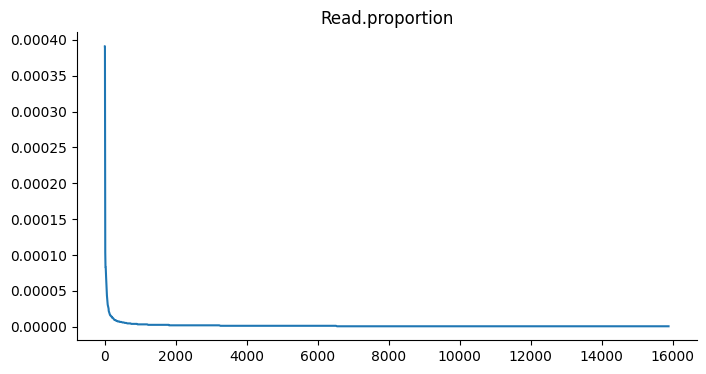

In [ ]:
# @title Read.proportion

from matplotlib import pyplot as plt
full_vj['Read.proportion'].plot(kind='line', figsize=(8, 4), title='Read.proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
full_vj['antigen.species'].value_counts()

,count
antigen.species,
CMV,645
EBV,211
InfluenzaA,150
SARS-CoV-2,115
HomoSapiens,87
HIV-1,67
DENV,31
YFV,28
HCV,27
